In [1]:
import numpy as np
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

device = "cuda" if torch.cuda.is_available() else "cpu"


# Loading Data and Model

In [2]:
def load_victim(model_dir="victim_model"):
    model_path = os.path.join(BASE_DIR, model_dir)
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
    model = DistilBertForSequenceClassification.from_pretrained(model_path).to(device)
    model.eval()
    return model, tokenizer

In [18]:
def tokenize_batch(batch):
    return tokenizer(batch["text"],truncation=True,padding="max_length",max_length=256)

def read_shadow_data(file_path):
  df = pd.read_csv(file_path)
  raw_ds = Dataset.from_pandas(df.rename(columns={"label": "labels"})[["text", "labels"]])
  shadow_source_ds = raw_ds.map(tokenize_batch, batched=True)
  shadow_source_ds = shadow_source_ds.remove_columns(["text"])
  return shadow_source_ds

def read_membership_data(file_path):
  membership_data = np.loadtxt(file_path, dtype=int)
  membership_data = membership_data[membership_data[:,0].argsort()]
  membership_labels = membership_data[:,1]  # array of 0/1

  member_idx = np.where(membership_labels == 1)[0].tolist()
  nonmember_idx = np.where(membership_labels == 0)[0].tolist()
  target_nonmember_ds = shadow_source_ds.select(nonmember_idx)
  target_member_ds = shadow_source_ds.select(member_idx)
  return target_member_ds, target_nonmember_ds

In [4]:
def make_shadow_splits(dataset, num_shadows=5, shadow_train_frac=0.5, seed=0):
    """
    dataset: Tokenized Dataset
    Returns: list of (train_ds, out_ds) for each shadow
    """
    rng = np.random.default_rng(seed)
    n = len(dataset)
    indices = np.arange(n)

    shadow_pairs = []
    for s in range(num_shadows):
        rng.shuffle(indices)
        cut = int(shadow_train_frac * n)
        train_idx = indices[:cut]
        out_idx   = indices[cut:]

        train_ds = dataset.select(train_idx.tolist())
        out_ds   = dataset.select(out_idx.tolist())
        shadow_pairs.append((train_ds, out_ds))

    return shadow_pairs

In [5]:
def safe_collate(batch):
    def to_tensor(x):
        # already tensor?
        if isinstance(x, torch.Tensor):
            return x
        # HF Datasets sometimes give lists/np arrays
        return torch.tensor(x)

    input_ids = torch.stack([to_tensor(x["input_ids"]) for x in batch])
    attention_mask = torch.stack([to_tensor(x["attention_mask"]) for x in batch])
    labels = torch.stack([to_tensor(x["labels"]) for x in batch])

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }


def make_loader(ds, batch_size=16, shuffle=True):
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, collate_fn=safe_collate)

In [6]:
class NoisyLabelCrossEntropy(nn.Module):
    def __init__(self, noise_rate, num_classes):
        super().__init__()
        self.eta = noise_rate
        self.C = num_classes

    def forward(self, logits, targets):
        log_probs = F.log_softmax(logits, dim=-1)

        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.eta / (self.C - 1))
            true_dist.scatter_(1, targets.unsqueeze(1), 1 - self.eta)

        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

In [7]:
def train_shadow_model(victim_dir, train_ds, val_ds=None, epochs=2, lr=2e-5, batch_size=16, noise_rate=0.2):

    model = DistilBertForSequenceClassification.from_pretrained(os.path.join(BASE_DIR, victim_dir)).to(device)
    model.train()

    train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = make_loader(val_ds, batch_size=batch_size, shuffle=False) if val_ds else None

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    total_steps = epochs * len(train_loader)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps
    )

    loss_fn = NoisyLabelCrossEntropy(noise_rate=noise_rate, num_classes=4)

    for ep in range(epochs):
        running = 0.0
        for batch in train_loader:
            batch = {k:v.to(device) for k,v in batch.items()}
            out = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            loss = loss_fn(out.logits, batch["labels"])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            running += loss.item()

        print(f"[shadow] epoch {ep+1}/{epochs} loss={running/len(train_loader):.4f}")

    model.eval()
    return model

In [8]:
import torch.nn.functional as F

@torch.no_grad()
def extract_features(model, ds, batch_size=32):
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, collate_fn=safe_collate)
    # loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_features = []

    loss_fn = nn.CrossEntropyLoss(reduction="none")

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attn, output_hidden_states=True)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)

        hidden = outputs.hidden_states[-1]  # last layer hidden state
        cls_embed = hidden[:,0,:]

        # 1. Loss
        losses = loss_fn(logits, labels)

        # 2. Confidence
        conf = probs.max(dim=-1)[0]

        # 3. Margin
        top2 = torch.topk(probs, k=2, dim=-1).values
        margin = top2[:, 0] - top2[:, 1]

        # 4. Entropy
        entr = -(probs * probs.log()).sum(dim=-1)

        # 5. Correctness
        preds = probs.argmax(dim=-1)
        correct = (preds == labels).float()

        # 6. Logit margin
        top2 = torch.topk(probs, k=2, dim=-1).values
        logit_margin = top2[:, 0] - top2[:, 1]

        # 7. Logit norm
        logit_norm = logits.norm(dim=-1)

        # 8. Class norm

        cls_norm = cls_embed.norm(dim=1)

        feats = torch.stack([
            losses,
            conf,
            # margin,
            entr,
            correct,
            logit_margin,
            # logit_norm,
            # p_true,
            # wrong_conf,
            # cls_norm
        ], dim=1)


        # collect
        all_features.append(feats.cpu().numpy())

    # return shape (N, 5)
    return np.concatenate(all_features, axis=0)

In [9]:
def build_attack_dataset(victim_dir, shadow_pairs,
                         shadow_epochs=2, batch_size=16, shadow_noise_rate=0.2, shadow_lr=8e-6):
    """
    For each shadow:
      - train on shadow train split (members)
      - compute losses on members and non-members
    Returns: X (losses), y (membership labels)
    """
    X_list, y_list = [], []

    for i, (in_ds, out_ds) in enumerate(shadow_pairs):
        print(f"\n=== Training shadow {i+1}/{len(shadow_pairs)} ===")
        shadow_model = train_shadow_model(
            victim_dir, in_ds, epochs=shadow_epochs, batch_size=batch_size, noise_rate=shadow_noise_rate, lr=shadow_lr
        )

        in_features  = extract_features(shadow_model, in_ds, batch_size=batch_size)
        out_features = extract_features(shadow_model, out_ds, batch_size=batch_size)

        X_list.append(in_features)
        X_list.append(out_features)

        y_list.append(np.ones(len(in_features)))      # members = 1
        y_list.append(np.zeros(len(out_features)))      # members = 1

    X = np.concatenate(X_list, axis=0).reshape(-1, in_features.shape[1])  # (M,1)
    y = np.concatenate(y_list, axis=0).astype(np.int64)

    return X, y

In [10]:
class AttackMLP(nn.Module):
    def __init__(self, in_dim=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.LeakyReLU(0.1),

            nn.Linear(16, 1)
        )


    def forward(self, x):
        return self.net(x)



In [11]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        # logits: (N,1), raw scores from model
        # targets: (N,1), 0/1 labels

        bce = F.binary_cross_entropy_with_logits(
            logits, targets, reduction="none"
        )

        # probability after sigmoid
        probs = torch.sigmoid(logits)

        # focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # class-balancing factor (alpha)
        alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        loss = alpha_factor * focal_weight * bce

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

In [12]:
def train_attack_model(
        X, y,
        epochs=20,
        lr=1e-4,
        batch_size=128,
        lbfgs_steps=10
    ):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    ds = torch.utils.data.TensorDataset(X_t, y_t)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    attack = AttackMLP(in_dim=X.shape[1]).to(device)

    # ---- Adam optimizer ----
    opt = torch.optim.AdamW(attack.parameters(), lr=lr)

    # ---- LR Scheduler ----
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt,
        mode="min",
        factor=0.5,
        patience=2,
        threshold=1e-3
    )
    num_pos = float(y_t.sum().item())
    num_neg = float(len(y_t) - num_pos)
    pos_weight = num_neg / (num_pos + 1e-8)
    bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))
    # bce = FocalLoss(alpha=0.25, gamma=2.0)

    print(f"\n=== Training attack model (Adam + LBFGS) ===")

    for ep in range(epochs):

        attack.train()
        running = 0.0

        # ----------------------------
        #   PHASE 1 — Adam optimizer
        # ----------------------------
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)

            logits = attack(xb)
            loss = bce(logits, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            running += loss.item()

        # LR scheduler step
        scheduler.step(running / len(dl))

        # Print every few epochs
        if ep % max(1, epochs // 10) == 0:
            print(f"[AdamW {ep+1}/{epochs}] loss = {running/len(dl):.4f}")

    # =====================================
    #   PHASE 2 — LBFGS refinement
    # =====================================

    print("\n=== Refining with LBFGS ===")

    # Define LBFGS optimizer (must use FULL batch!)
    lbfgs = torch.optim.LBFGS(
        attack.parameters(),
        lr=0.1,               # LBFGS uses a different internal rule
        max_iter=20,
        history_size=50,
        line_search_fn="strong_wolfe"
    )

    full_x = X_t.to(device)
    full_y = y_t.to(device)

    def closure():
        lbfgs.zero_grad()
        logits = attack(full_x)
        loss = bce(logits, full_y)
        loss.backward()
        return loss

    # Perform LBFGS refinement steps
    for i in range(lbfgs_steps):
        loss_val = lbfgs.step(closure)
        print(f"  LBFGS step {i+1}/{lbfgs_steps}: loss={loss_val.item():.6f}")

    attack.eval()
    return attack

In [13]:
@torch.no_grad()
def attack_victim(attack_model, victim_model, member_ds, nonmember_ds, batch_size=32):
    m_features = extract_features(victim_model, member_ds, batch_size=batch_size)
    nm_features = extract_features(victim_model, nonmember_ds, batch_size=batch_size)

    X_test = np.concatenate([m_features, nm_features], axis=0)
    y_true = np.concatenate([
        np.ones(len(m_features)),
        np.zeros(len(nm_features))
    ])

    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    probs = torch.sigmoid(attack_model(X_test_t)).cpu().numpy().squeeze()

    y_pred = (probs > 0.5).astype(np.int64)
    results = {}
    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['roc_auc'] = float(roc_auc_score(y_true, probs))
    results['precision'] = precision_score(y_true, y_pred)
    results['recall'] = recall_score(y_true, y_pred)
    results['f1'] = f1_score(y_true, y_pred)
    results['confusion_matrix'] = confusion_matrix(y_true, y_pred)
    # results['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)

    print(f"\nVictim attack accuracy: {results['accuracy']*100:.2f}% ROC AUC: {results['roc_auc']*100:.2f}%")
    return results, probs, y_true

In [14]:
def train_feature_based_mia(
    victim_dir,
    shadow_source_ds,      # fake data pool for shadows
    num_shadows=5,
    shadow_train_frac=0.5,
    shadow_noise_rate=0.2,
    shadow_epochs=10,
    batch_size=16,
    attack_model_epochs=20,
    attack_lr=1e-4
):

    victim_model, tokenizer = load_victim(victim_dir)

    shadow_pairs = make_shadow_splits(
        shadow_source_ds,
        num_shadows=num_shadows,
        shadow_train_frac=shadow_train_frac
    )

    X_attack, y_attack = build_attack_dataset(
        victim_dir, shadow_pairs,
        shadow_epochs=shadow_epochs,
        batch_size=batch_size,
        shadow_noise_rate=shadow_noise_rate,
        shadow_lr=8e-5
    )

    attack_model = train_attack_model(X_attack, y_attack, epochs=attack_model_epochs, lr=attack_lr)
    return attack_model

In [15]:
def evaluate_feature_based_mia(attack_model, victim_dir, target_member_ds, target_nonmember_ds, batch_size=32):

  victim_model, tokenizer = load_victim(victim_dir)
  victim_model.eval()
  attack_model.eval()

  results, probs, y_true = attack_victim(
          attack_model, victim_model,
          target_member_ds, target_nonmember_ds,
          batch_size=batch_size
          )

  return results

def mia_predict_from_df(source_ds, tokenizer,victim_model, attack_model, device, batch_size=32):
    attack_model.eval()
    source_ds.set_format(type="torch",columns=["input_ids", "attention_mask", "labels"])
    feats = extract_features(victim_model, source_ds, batch_size=32)
    feats = torch.as_tensor(feats, dtype=torch.float32).to(device)
    with torch.no_grad():
      preds = attack_model(feats).sigmoid().cpu().numpy()
    return preds
def save_predictions_to_file(preds, file_path):
  labels = (preds >= 0.5).astype(int)
  txt = "\n".join([f'{i} {l[0]}' for i, l in enumerate(labels)])

  with open(file_path, 'w') as f:
    f.write(txt)

In [17]:
if __name__ == "__main__":
  BASE_DIR = '/content/drive/MyDrive/PrivacyAwareComputing/ProjectMIALM'
  victim_dir = 'victim_model_distilbert_agnews'
  MODE='validation'
  # MODE= 'train'
  target_member_ds, target_nonmember_ds = None, None
  file_path = None

  victim_model, tokenizer = load_victim(victim_dir)

  if MODE == 'validation':
    print('Loading validation dataset')
    file_path = os.path.join(BASE_DIR, 'validation_samples.csv')
    shadow_source_ds = read_shadow_data(file_path)
    target_member_ds, target_nonmember_ds = read_membership_data(os.path.join(BASE_DIR, 'validation_results.txt'))
    assert (target_member_ds.shape[0]+ target_nonmember_ds.shape[0] == shadow_source_ds.shape[0])
  elif MODE == 'train':
    print('Loading testing dataset')
    file_path = os.path.join(BASE_DIR, 'sampled.csv')
    shadow_source_ds = read_shadow_data(file_path)


  attack_model = train_feature_based_mia(
      victim_dir=victim_dir,
      shadow_source_ds=shadow_source_ds,
      num_shadows=5,
      shadow_train_frac=0.5,
      shadow_noise_rate=0.02,
      shadow_epochs=5,
      batch_size=32,
      attack_model_epochs=500,
      attack_lr=1e-2
  )
  if MODE == 'train':
    test_source_ds = read_shadow_data(os.path.join(BASE_DIR, 'sampled.csv'))
    preds = mia_predict_from_df(test_source_ds, tokenizer, victim_model, attack_model, device, batch_size=32)
    save_predictions_to_file(preds, os.path.join(BASE_DIR, 'mia_lm_results.txt'))


Loading validation dataset


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


=== Training shadow 1/5 ===
[shadow] epoch 1/5 loss=0.4515
[shadow] epoch 2/5 loss=0.3295
[shadow] epoch 3/5 loss=0.2645
[shadow] epoch 4/5 loss=0.2151
[shadow] epoch 5/5 loss=0.2035

=== Training shadow 2/5 ===
[shadow] epoch 1/5 loss=0.4414
[shadow] epoch 2/5 loss=0.3532
[shadow] epoch 3/5 loss=0.2876
[shadow] epoch 4/5 loss=0.2336
[shadow] epoch 5/5 loss=0.1966

=== Training shadow 3/5 ===
[shadow] epoch 1/5 loss=0.4455
[shadow] epoch 2/5 loss=0.3381
[shadow] epoch 3/5 loss=0.2674
[shadow] epoch 4/5 loss=0.2460
[shadow] epoch 5/5 loss=0.2118

=== Training shadow 4/5 ===
[shadow] epoch 1/5 loss=0.5329
[shadow] epoch 2/5 loss=0.3982
[shadow] epoch 3/5 loss=0.3031
[shadow] epoch 4/5 loss=0.2671
[shadow] epoch 5/5 loss=0.2504

=== Training shadow 5/5 ===
[shadow] epoch 1/5 loss=0.4241
[shadow] epoch 2/5 loss=0.3139
[shadow] epoch 3/5 loss=0.2425
[shadow] epoch 4/5 loss=0.2115
[shadow] epoch 5/5 loss=0.1961

=== Training attack model (Adam + LBFGS) ===
[AdamW 1/500] loss = 0.6800
[AdamW

# Save Results

In [19]:
test_source_ds = read_shadow_data(os.path.join(BASE_DIR, 'sampled.csv'))
preds = mia_predict_from_df(test_source_ds, tokenizer, victim_model, attack_model, device, batch_size=32)
save_predictions_to_file(preds, os.path.join(BASE_DIR, 'mia_lm_results.txt'))

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

# Visualize Results

In [57]:
def plot_confusion_matrix_from_counts(cm, labels=["Non-Member", "Member"]):
    cm = np.array(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Membership Inference Attack – Confusion Matrix")
    plt.tight_layout()
    plt.show()


Victim attack accuracy: 38.10% ROC AUC: 52.12%
ROC AUC: 0.5211878609735974, Precision: 0.19887165021156558
Recall: 0.734375, F1 Score: 0.3129855715871254
Accuracy: 0.381


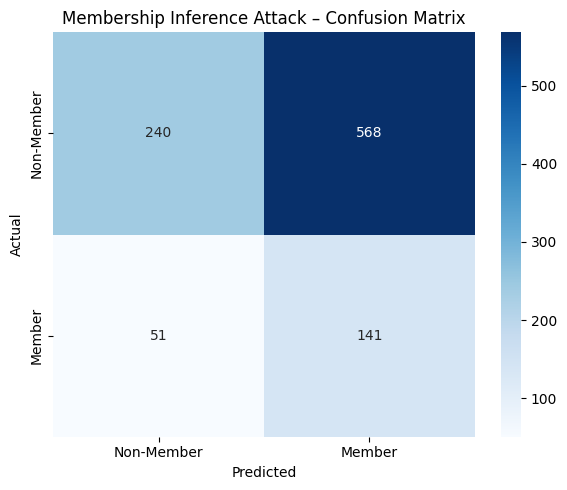

In [58]:
if MODE == 'validation':
  results = evaluate_feature_based_mia(attack_model, victim_dir, target_member_ds, target_nonmember_ds, batch_size=32)
  print(f'ROC AUC: {results['roc_auc']}, Precision: {results['precision']}')
  print(f'Recall: {results['recall']}, F1 Score: {results['f1']}')
  print(f'Accuracy: {results['accuracy']}' )
  plot_confusion_matrix_from_counts(results['confusion_matrix'])
